In [261]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [262]:
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import learning_curve 
import optuna
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
optuna.logging.set_verbosity(0)
import warnings
warnings.filterwarnings("ignore")

In [263]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv",index_col = 'PassengerId')  # тренировочные с ответами
X_test = pd.read_csv("/kaggle/input/titanic/test.csv",index_col = 'PassengerId')   # тестовые без ответов
Y_submit = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")    # ответы на тестовые

In [264]:
#X_train, Y_train = df_train.drop(['Survived'],axis = 1), df_train['Survived'].values

In [265]:
X_train = df_train
X_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [266]:
# Вывести информацию об уникальных значениях по каждому столбцу. Способ 1
list_i = []
list_el = []
list_unique = []
list_nunique = []

for i,el in enumerate (X_train.select_dtypes(include=['int64','float64']).columns):
    
    list_i.append(i)
    list_el.append(el)
    list_unique.append(X_train.select_dtypes(include=['int64','float64'])[el].unique())
    list_nunique.append(X_train.select_dtypes(include=['int64','float64'])[el].nunique())
    
series_1 = pd.Series(list_i)
series_2 = pd.Series(list_el)
series_3 = pd.Series(list_unique)
series_4 = pd.Series(list_nunique)

value_info = pd.DataFrame({'feature':series_2,'unique_values':series_3,'n_unique':series_4})
value_info
#value_info['n_NAN'] = value_info['unique_values'].count('nan')

,feature,unique_values,n_unique
0,Survived,"[0, 1]",2
1,Pclass,"[3, 1, 2]",3
2,Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",88
3,SibSp,"[1, 0, 3, 4, 2, 5, 8]",7
4,Parch,"[0, 1, 2, 5, 3, 4, 6]",7
5,Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248


In [267]:
# Функция доли выбросов
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def outliers_report(df):
    """
    Выявляет выбросы в числовых столбцах DataFrame.

    Returns:
               outliers_df: DataFrame с границами выбросов и долей выбросов
               outlier_metrics: Список мер удаленности выбросов (процентилей)
               outlier_indices: Список индексов строк с выбросами
    """
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    lower_norms = {}
    upper_norms = {}
    out_parts = {}
    outlier_indices = []
    outlier_metrics = []

    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        median = df[col].quantile(0.5)

        lower_norm = median - 1.5 * iqr
        upper_norm = median + 1.5 * iqr

        lower_norms[col] = lower_norm  # заполнить пустой словарь
        upper_norms[col] = upper_norm

        # Считаем долю выбросов 
        outliers = df[(df[col] < lower_norm) | (df[col] > upper_norm)][col]
        out_parts[col] = len(outliers) / len(df[col])

        # Собираем индексы и метрики
        for index, value in outliers.items():  #Итерируемся по выбросам
            outlier_indices.append(index)
            percentile = percentileofscore(df[col], value)
            outlier_metrics.append(min(percentile, 100 - percentile)) 

    # Создаем DataFrame с результатами
    outliers_data = {'lower_norm': lower_norms, 'upper_norm': upper_norms, 'out_part': out_parts}
    outliers_df = pd.DataFrame(outliers_data).transpose()  # Транспонируем для правильной структуры

    # Сортируем метрики и индексы
    sorted_metrics, sorted_indices = zip(*sorted(zip(outlier_metrics, outlier_indices))) if outlier_metrics else ([], []) # Обрабатываем случай пустых списков

    return outliers_df
    #return sorted_metrics
    #return sorted_indices

In [268]:
# Функция определения доли пропущенных значений по столбцам
def miss_data(df):

    x = ['column_name','missing_data', 'missing_in_percentage']
    missing_data = pd.DataFrame(columns=x)
    columns = df.columns
    
    for col in columns:
        icolumn_name = col
        imissing_data = df[col].isnull().sum()
        imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100
        
        missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
    print(missing_data) 

In [269]:
# Описательная статистика
X_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [270]:
# Вывести информацию об уникальных значениях по каждому столбцу. Способ 2
def value_info(df):
    
    value_info_1 = pd.Series({c: df[c].unique() for c in df}).to_frame().reset_index()
    nuniques = []
    
    for col in df.columns:
        nuniques.append(X_train[col].nunique())
        
    value_info_1['nuniques'] = nuniques
    return value_info_1

In [271]:
outliers_report(X_train)

,Survived,Pclass,Age,SibSp,Parch,Fare
lower_norm,-1.5,1.500000,1.187500,-1.500000,0.000000,-20.180200
upper_norm,1.5,4.500000,54.812500,1.500000,0.000000,49.088600
out_part,0.0,0.242424,0.062851,0.083053,0.239057,0.184063


In [272]:
miss_data(X_train)

   column_name  missing_data  missing_in_percentage
0     Survived             0               0.000000
1       Pclass             0               0.000000
2         Name             0               0.000000
3          Sex             0               0.000000
4          Age           177              19.865320
5        SibSp             0               0.000000
6        Parch             0               0.000000
7       Ticket             0               0.000000
8         Fare             0               0.000000
9        Cabin           687              77.104377
10    Embarked             2               0.224467


In [273]:
value_info(X_train).rename(columns = {'index':'feature',0:'unique_values'})

,feature,unique_values,nuniques
0,Survived,"[0, 1]",2
1,Pclass,"[3, 1, 2]",3
2,Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",891
3,Sex,"[male, female]",2
4,Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",88
5,SibSp,"[1, 0, 3, 4, 2, 5, 8]",7
6,Parch,"[0, 1, 2, 5, 3, 4, 6]",7
7,Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",681
8,Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248
9,Cabin,"[nan, C85, C123, E46, G6, C103, D56, A6, C23 C...",147


In [274]:
X_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [276]:
def filling(df):
    for i in df.select_dtypes(include=["int64", "float64"]).columns:
        med = df.loc[:,i].median()
        df.loc[:,i] = df.loc[:,i].fillna(med)
    df = df.drop(['Cabin','Name','Ticket'],axis = 1) # Удалим столбец, состоящий из пропусков на 77% и столбцы с большинством уникальных значений
    for i in df.select_dtypes(include=["object"]).columns:
        df = df.dropna()
    return df

In [277]:
X_train = filling(X_train)
X_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,28.0,1,2,23.4500,S


In [278]:
X_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.315152,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.984932,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [279]:
# Чтобы получить в виде датафрейма - нужно вызывать отдельно и без print
print(X_train.describe())
print(value_info(X_train).rename(columns = {'index':'feature',0:'unique_values'}))
print(miss_data(X_train))
print(outliers_report(X_train))

         Survived      Pclass         Age       SibSp       Parch        Fare
count  889.000000  889.000000  889.000000  889.000000  889.000000  889.000000
mean     0.382452    2.311586   29.315152    0.524184    0.382452   32.096681
std      0.486260    0.834700   12.984932    1.103705    0.806761   49.697504
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.895800
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
    feature                                      unique_values  nuniques
0  Survived                                             [0, 1]         2
1    Pclass                                          [3, 1, 2]         3
2       Sex                                     [male, female]         2
3     

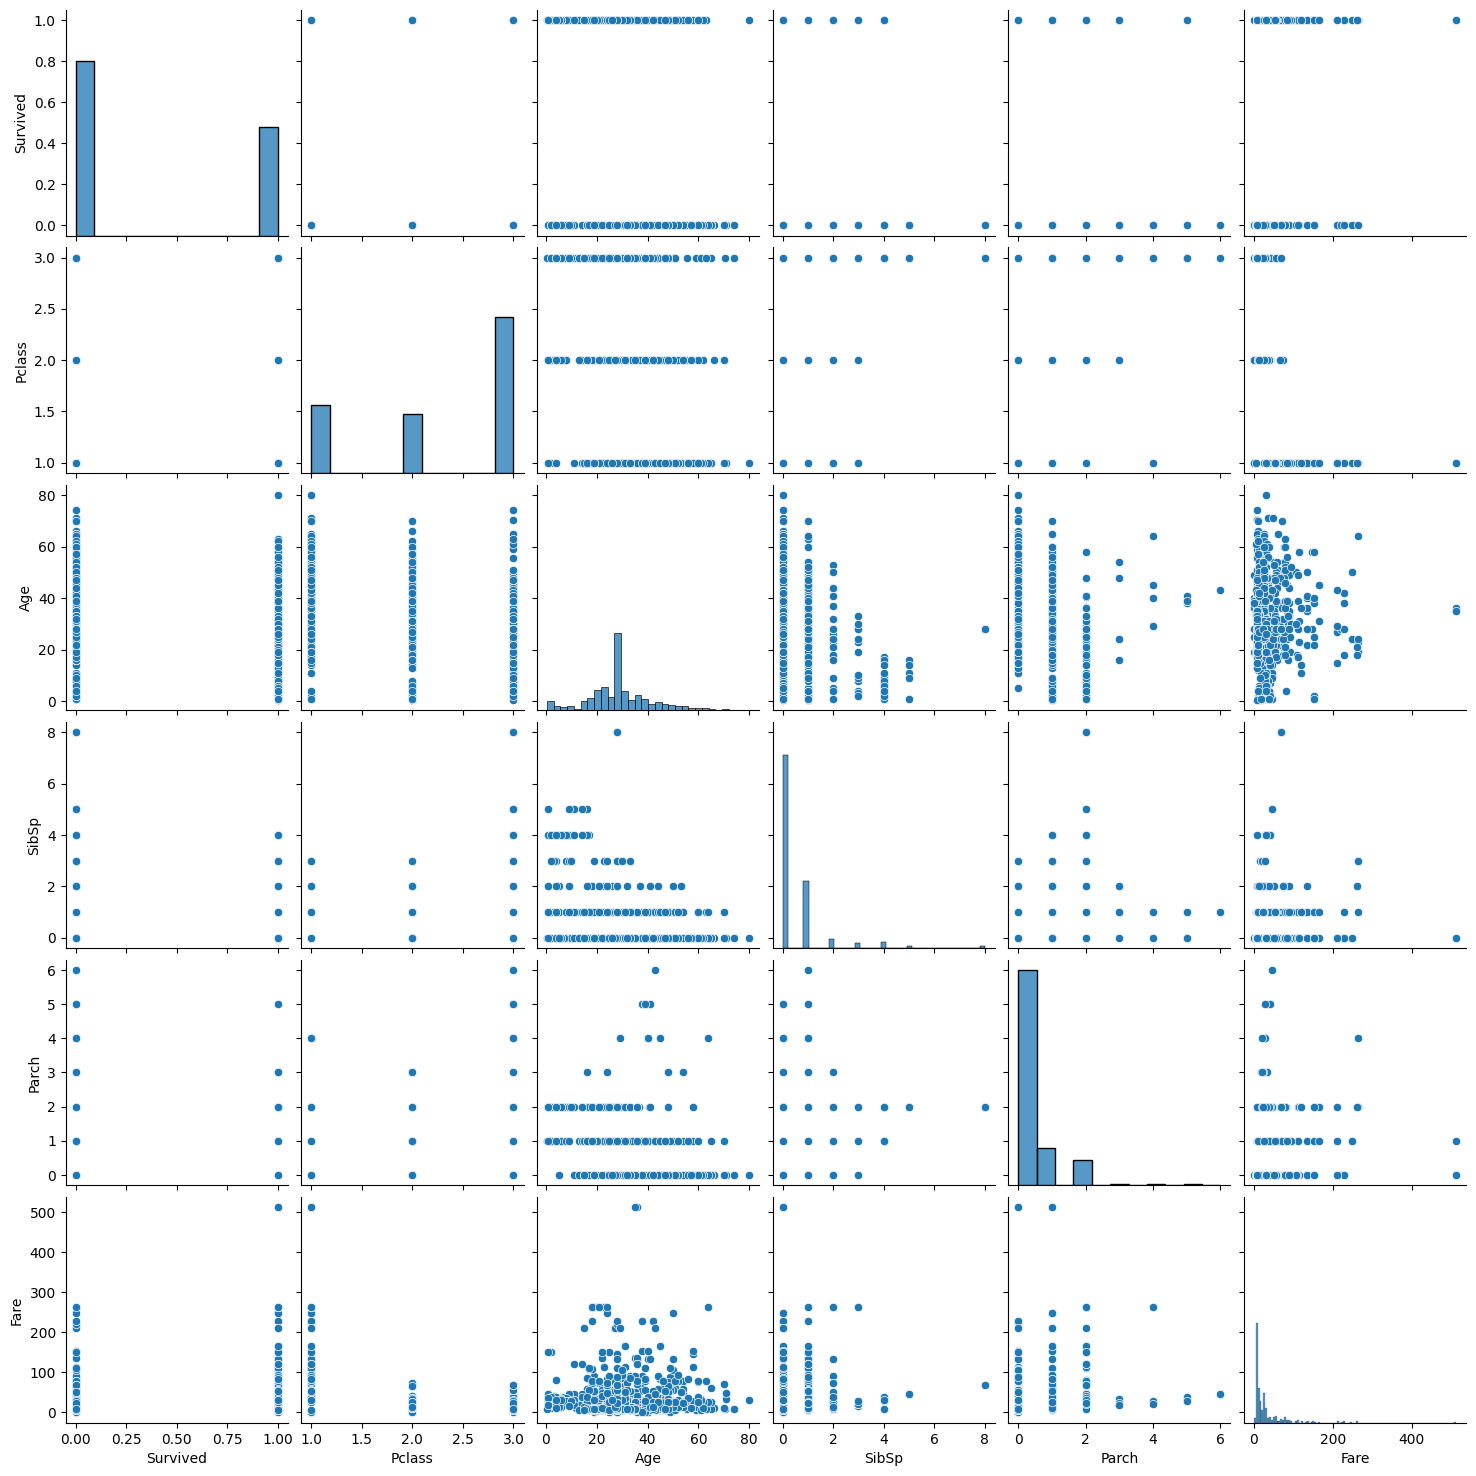

In [280]:
# Видим, что в Age было слишком много пропусков для заполнения медианой - лучше обучить модель для заполнения этого столбца
import seaborn as sns
sns.pairplot(X_train)

In [281]:
X_train, Y_train = X_train.drop(['Survived'],axis = 1), X_train['Survived'].values
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
887,2,male,27.0,0,0,13.0000,S
888,1,female,19.0,0,0,30.0000,S
889,3,female,28.0,1,2,23.4500,S


In [282]:
'''
# Scaling и one-hot-encoding
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
scale = StandardScaler()
obj_columns = X_train.select_dtypes(include=['object']).columns.tolist()
for_one_hot_encoding = pd.get_dummies(X_train.select_dtypes(include=['object']))
X_train = X_train.drop(obj_columns, axis = 1)
X_train = pd.concat([X_train,for_one_hot_encoding], axis = 1)
# X_train = scale.trainsform(X_train.select_dtypes(include=['int64','float64']))  scaling
X_train
'''

"\n# Scaling и one-hot-encoding\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder\nscale = StandardScaler()\nobj_columns = X_train.select_dtypes(include=['object']).columns.tolist()\nfor_one_hot_encoding = pd.get_dummies(X_train.select_dtypes(include=['object']))\nX_train = X_train.drop(obj_columns, axis = 1)\nX_train = pd.concat([X_train,for_one_hot_encoding], axis = 1)\n# X_train = scale.trainsform(X_train.select_dtypes(include=['int64','float64']))  scaling\nX_train\n"

In [283]:
# Scaling и one-hot-encoding
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder


def preprocessing(df):
    scale = StandardScaler()
    obj_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    for_one_hot_encoding = pd.get_dummies(df.select_dtypes(include=['object']))
    
    df = df.drop(obj_columns, axis = 1)
    df = pd.concat([df,for_one_hot_encoding], axis = 1)
    
    return df

In [284]:
X_train = preprocessing(X_train)
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,22.0,1,0,7.2500,False,True,False,False,True
2,1,38.0,1,0,71.2833,True,False,True,False,False
3,3,26.0,0,0,7.9250,True,False,False,False,True
4,1,35.0,1,0,53.1000,True,False,False,False,True
5,3,35.0,0,0,8.0500,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
887,2,27.0,0,0,13.0000,False,True,False,False,True
888,1,19.0,0,0,30.0000,True,False,False,False,True
889,3,28.0,1,2,23.4500,True,False,False,False,True


In [285]:
sizes, training_scores, testing_scores = learning_curve(CatBoostClassifier(verbose=0), X_train, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))

(Text(0.5, 0, 'Training Set Size'), Text(0, 0.5, 'Accuracy Score'))

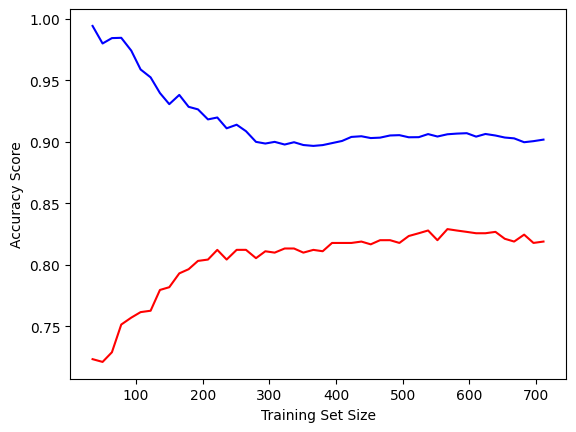

In [286]:
mean_training = np.mean(training_scores, axis=1)
mean_testing = np.mean(testing_scores, axis=1) 
plt.plot(sizes, mean_training, color = 'blue')
plt.plot(sizes, mean_testing, color = 'red')
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score")

In [287]:
'''
import catboost as cb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
optuna.logging.set_verbosity(0)
# optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective_cat(trial):
    params = {
     'iterations': trial.suggest_int('iterations', 20, 100),
     'loss_function': 'Logloss',
     'eval_metric': 'AUC',
     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
     'depth': trial.suggest_int('depth', 6, 12),
     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0),
     }
    model = CatBoostClassifier(**params)
    model.fit(X_train, Y_train)
    accuracy = cross_val_score(model,X_train,Y_train,scoring = 'accuracy',cv = 6).mean()
    return accuracy

study = optuna.create_study(direction = 'maximize')
study.optimize(objective_cat, n_trials=25, timeout=600)
study.best_params_
'''

"\nimport catboost as cb\nfrom catboost import CatBoostClassifier\nimport optuna\nfrom sklearn.model_selection import cross_val_score\noptuna.logging.set_verbosity(0)\n# optuna.logging.set_verbosity(optuna.logging.WARNING)\ndef objective_cat(trial):\n    params = {\n     'iterations': trial.suggest_int('iterations', 20, 100),\n     'loss_function': 'Logloss',\n     'eval_metric': 'AUC',\n     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),\n     'depth': trial.suggest_int('depth', 6, 12),\n     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0),\n     }\n    model = CatBoostClassifier(**params)\n    model.fit(X_train, Y_train)\n    accuracy = cross_val_score(model,X_train,Y_train,scoring = 'accuracy',cv = 6).mean()\n    return accuracy\n\nstudy = optuna.create_study(direction = 'maximize')\nstudy.optimize(objective_cat, n_trials=25, timeout=600)\nstudy.best_params_\n"

In [288]:
# Best trial with value: 0.8338775016627366
best_params_cat = {'iterations': 50, 'learning_rate': 0.24655150690051955, 'depth': 10, 
 'l2_leaf_reg': 0.6361027026487054}

cat_boost = CatBoostClassifier(verbose = 0, **best_params_cat)
cat_boost.fit(X_train, Y_train)

X_test = preprocessing(filling(X_test))
y_pred = cat_boost.predict_proba(X_test)#[:, 1]
y_pred

array([[0.9536951 , 0.0463049 ],
       [0.86912997, 0.13087003],
       [0.64244429, 0.35755571],
       [0.82042726, 0.17957274],
       [0.53704272, 0.46295728],
       [0.85926355, 0.14073645],
       [0.44544346, 0.55455654],
       [0.89881109, 0.10118891],
       [0.08450623, 0.91549377],
       [0.95573571, 0.04426429],
       [0.84427976, 0.15572024],
       [0.8293679 , 0.1706321 ],
       [0.02846611, 0.97153389],
       [0.89030542, 0.10969458],
       [0.02423221, 0.97576779],
       [0.03021788, 0.96978212],
       [0.90693042, 0.09306958],
       [0.63572916, 0.36427084],
       [0.80471616, 0.19528384],
       [0.78685475, 0.21314525],
       [0.33630133, 0.66369867],
       [0.56006755, 0.43993245],
       [0.02044991, 0.97955009],
       [0.37498902, 0.62501098],
       [0.03186573, 0.96813427],
       [0.97903348, 0.02096652],
       [0.00600246, 0.99399754],
       [0.63572916, 0.36427084],
       [0.45142377, 0.54857623],
       [0.67914874, 0.32085126],
       [0.